In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For ANOVA or Kruskal-Wallis

# Optional: Configure matplotlib for better inline plotting
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size

# Define paths to cleaned data files
BASE_DATA_PATH = '../data/'
COUNTRIES = ['Senegal', 'Benin', 'Togo'] # Or whatever your country names are
FILE_SUFFIX = '_clean.csv'

# Define common metrics to compare
METRICS_TO_COMPARE = ['ghi_sil', 'dhi_rsi', 'ghi_pyr'] # Adjust based on your actual GHI, DNI, DHI column names
# Check your cleaned CSVs for the exact GHI, DNI, DHI column names you decided on
# For example, if DNI isn't directly available or you created a proxy, use that.
# For now, assuming ghi_sil = GHI, dhi_rsi = DHI. If you have a DNI column, add it.
# If 'ghi_pyr' is another GHI, you might focus on one primary GHI for comparison.
# Let's assume 'ghi_sil' is primary GHI, 'dhi_rsi' is DHI. We need a DNI column.
# If DNI is not available in your cleaned data, you'll have to skip DNI comparisons or note its absence.
# For this example, let's assume you have columns named 'GHI', 'DNI', 'DHI' in your cleaned files
# For simplicity in the code below, I will use generic names like 'GHI_Selected', 'DNI_Selected', 'DHI_Selected'
# You MUST replace these with your actual column names from your cleaned files.

# *** IMPORTANT: Replace these with your actual column names for GHI, DNI, DHI ***
# These are the names of the columns in your *cleaned* CSV files.
GHI_COL = 'ghi_sil'  # Example, replace with your chosen GHI column
DHI_COL = 'dhi_rsi'  # Example, replace with your DHI column
DNI_COL = 'dni_calculated' # Example, IF YOU HAVE OR CALCULATED A DNI COLUMN. If not, remove DNI from comparisons.

# For demonstration, let's only use GHI and DHI if DNI is uncertain from previous steps
METRICS_FOR_PLOTTING = [GHI_COL, DHI_COL]
if DNI_COL in pd.read_csv(f"{BASE_DATA_PATH}{COUNTRIES[0].lower()}{FILE_SUFFIX}").columns: # Check if DNI_COL exists
    METRICS_FOR_PLOTTING.append(DNI_COL)
else:
    print(f"Warning: DNI column '{DNI_COL}' not found. DNI comparisons will be skipped or limited.")
    # You might want to remove DNI_COL from METRICS_FOR_PLOTTING if it doesn't exist
    if DNI_COL in METRICS_FOR_PLOTTING: METRICS_FOR_PLOTTING.remove(DNI_COL)

print(f"Metrics selected for comparison: {METRICS_FOR_PLOTTING}")

Metrics selected for comparison: ['ghi_sil', 'dhi_rsi']


In [2]:
print("--- Loading Cleaned Datasets ---")
all_dfs = {}
try:
    for country in COUNTRIES:
        file_path = f"{BASE_DATA_PATH}{country.lower()}{FILE_SUFFIX}"
        df_country = pd.read_csv(file_path)
        # Ensure 'time' column is datetime if not already (should be from EDA export)
        if 'time' in df_country.columns:
            df_country['time'] = pd.to_datetime(df_country['time'])
        all_dfs[country] = df_country
        print(f"Loaded data for {country}: {df_country.shape[0]} rows, {df_country.shape[1]} columns")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure all cleaned CSV files exist.")
    print("Please ensure 'benin_clean.csv', 'sierraleone_clean.csv' (or 'senegal_clean.csv'), and 'togo_clean.csv' are in the data/ folder.")
    # If using Senegal instead of Sierra Leone:
    # print("If using Senegal, ensure COUNTRIES list is updated and 'senegal_clean.csv' exists.")
    raise # Stop execution if files are missing

# Combine dataframes for easier plotting, adding a 'country' column
# We only need the metrics and country columns for comparison plots
combined_df_list = []
for country_name, df_country in all_dfs.items():
    # Select only the metrics we need for comparison
    # Check if all metrics are present in the current country's df
    available_metrics = [metric for metric in METRICS_FOR_PLOTTING if metric in df_country.columns]
    if not available_metrics:
        print(f"Warning: No metrics for plotting found in {country_name} data. Skipping this country for combined_df.")
        continue
        
    temp_df = df_country[available_metrics].copy()
    temp_df['country'] = country_name
    combined_df_list.append(temp_df)

if not combined_df_list:
    print("CRITICAL: No data to combine. Check metric names and file loading.")
    # raise ValueError("No data available for comparison.")
else:
    combined_df = pd.concat(combined_df_list, ignore_index=True)
    print(f"\nCombined DataFrame for plotting created with shape: {combined_df.shape}")
    print(combined_df.head())
    print(combined_df['country'].value_counts())

--- Loading Cleaned Datasets ---
Loaded data for Senegal: 561600 rows, 19 columns
Loaded data for Benin: 525601 rows, 1 columns
Loaded data for Togo: 525601 rows, 1 columns

Combined DataFrame for plotting created with shape: (561600, 3)
   ghi_sil  dhi_rsi  country
0      0.0      0.0  Senegal
1      0.0      0.0  Senegal
2      0.0      0.0  Senegal
3      0.0      0.0  Senegal
4      0.0      0.0  Senegal
Senegal    561600
Name: country, dtype: int64



--- Metric Comparison: Boxplots ---


C:\Users\HP\AppData\Local\Temp\ipykernel_22452\2343679887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=metric, data=combined_df, palette='viridis')


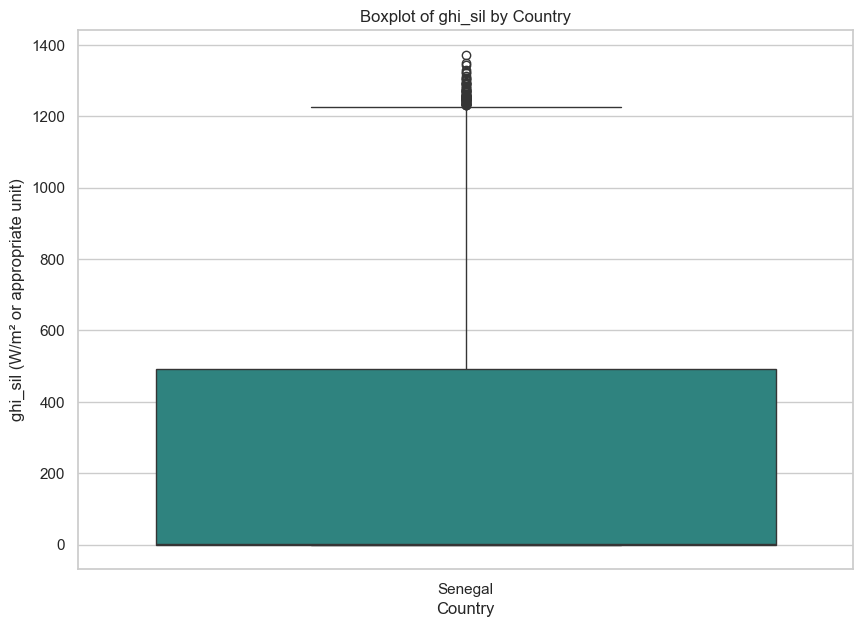

C:\Users\HP\AppData\Local\Temp\ipykernel_22452\2343679887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=metric, data=combined_df, palette='viridis')


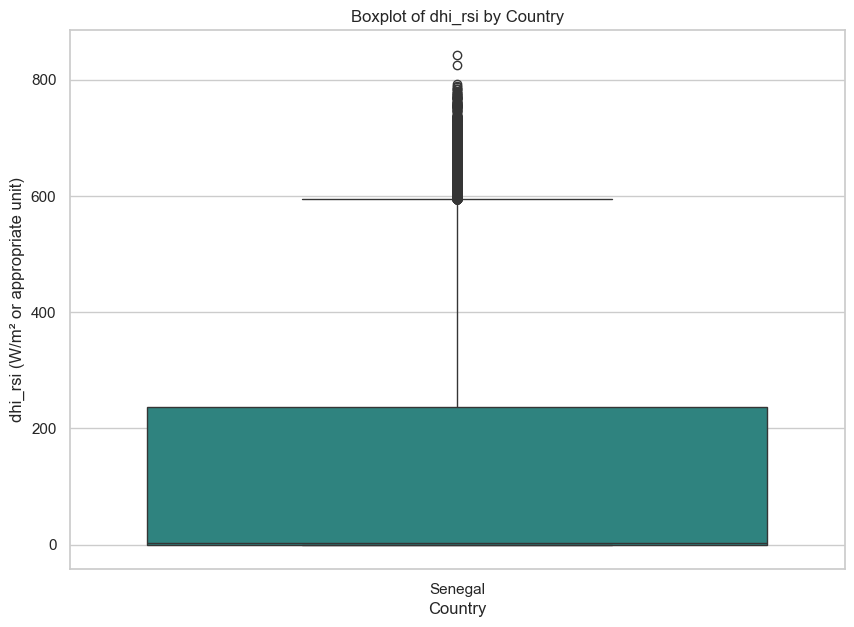

In [3]:
print("\n--- Metric Comparison: Boxplots ---")

if 'combined_df' not in locals() or combined_df.empty:
    print("Skipping boxplots: combined_df is not available or empty.")
else:
    for metric in METRICS_FOR_PLOTTING:
        if metric in combined_df.columns:
            plt.figure(figsize=(10, 7))
            sns.boxplot(x='country', y=metric, data=combined_df, palette='viridis')
            plt.title(f'Boxplot of {metric} by Country')
            plt.xlabel('Country')
            plt.ylabel(f'{metric} (W/m² or appropriate unit)')
            plt.show()
        else:
            print(f"Skipping boxplot for {metric}: column not found in combined_df.")

In [4]:
print("\n--- Metric Comparison: Summary Table ---")

if 'combined_df' not in locals() or combined_df.empty:
    print("Skipping summary table: combined_df is not available or empty.")
else:
    summary_stats_list = []
    for metric in METRICS_FOR_PLOTTING:
        if metric in combined_df.columns:
            # Group by country and calculate mean, median, std for the current metric
            stats_for_metric = combined_df.groupby('country')[metric].agg(['mean', 'median', 'std'])
            stats_for_metric.columns = pd.MultiIndex.from_product([[metric], stats_for_metric.columns]) # Create multi-index for columns
            summary_stats_list.append(stats_for_metric)
        else:
            print(f"Skipping summary stats for {metric}: column not found.")
            
    if summary_stats_list:
        summary_table = pd.concat(summary_stats_list, axis=1)
        print("Summary Table (Mean, Median, Std Dev) for GHI, DNI, DHI across countries:")
        # Transpose for potentially better readability or keep as is
        # print(summary_table.T) 
        print(summary_table)
    else:
        print("No summary statistics were generated.")


--- Metric Comparison: Summary Table ---
Summary Table (Mean, Median, Std Dev) for GHI, DNI, DHI across countries:
            ghi_sil                        dhi_rsi                    
               mean median         std        mean  median         std
country                                                               
Senegal  244.139533  2.802  327.301254  123.210055  2.9605  161.445836


In [5]:
print("\n--- Statistical Testing (ANOVA/Kruskal-Wallis on GHI) ---")

if 'combined_df' not in locals() or combined_df.empty or GHI_COL not in combined_df.columns:
    print(f"Skipping statistical tests: combined_df is not available, empty, or '{GHI_COL}' column missing.")
else:
    # Prepare data for ANOVA/Kruskal-Wallis: a list of arrays/series, one for each country's GHI values
    grouped_ghi_data = [combined_df[GHI_COL][combined_df['country'] == country].dropna() for country in COUNTRIES if country in combined_df['country'].unique()]
    
    # Ensure we have data for at least 2 groups for comparison
    grouped_ghi_data = [group for group in grouped_ghi_data if not group.empty] # Remove empty groups
    
    if len(grouped_ghi_data) < 2:
        print("Not enough country groups with GHI data to perform statistical test.")
    else:
        # Check for normality (e.g., Shapiro-Wilk test on samples) and homogeneity of variances (e.g., Levene's test)
        # to decide between ANOVA and Kruskal-Wallis.
        # For simplicity here, we'll show Kruskal-Wallis, which is non-parametric and doesn't assume normality.
        # If assumptions for ANOVA are met, it can be more powerful.
        
        print("Performing Kruskal-Wallis H-test for GHI across countries...")
        # Filter out any groups with too few samples if necessary, though kruskal handles this by ignoring them or erroring.
        # Let's ensure at least some samples per group
        min_samples_per_group = 5 # Arbitrary small number
        valid_groups_for_test = [group for group in grouped_ghi_data if len(group) >= min_samples_per_group]

        if len(valid_groups_for_test) < 2:
            print(f"Not enough groups with at least {min_samples_per_group} samples for Kruskal-Wallis test.")
        else:
            try:
                h_statistic, p_value = stats.kruskal(*valid_groups_for_test) # Unpack the list of series into arguments
                print(f"  Kruskal-Wallis H-statistic: {h_statistic:.4f}")
                print(f"  P-value: {p_value:.4f}")

                if p_value < 0.05:
                    print("  Interpretation: The p-value is less than 0.05, suggesting that there is a statistically significant difference in GHI distributions among at least two of the countries.")
                else:
                    print("  Interpretation: The p-value is greater than or equal to 0.05, suggesting that there is no statistically significant difference in GHI distributions among the countries (based on this test).")
            except Exception as e:
                print(f"  Error during Kruskal-Wallis test: {e}")
                print("  This can happen if groups have identical values or too few samples.")

        # If you wanted to do ANOVA (after checking assumptions):
        # from scipy.stats import f_oneway
        # f_statistic, p_value_anova = f_oneway(*grouped_ghi_data)
        # print(f"\nANOVA F-statistic: {f_statistic}")
        # print(f"ANOVA P-value: {p_value_anova}")


--- Statistical Testing (ANOVA/Kruskal-Wallis on GHI) ---
Not enough country groups with GHI data to perform statistical test.



--- (Bonus) Visual Summary: Bar Chart Ranking by Average GHI ---


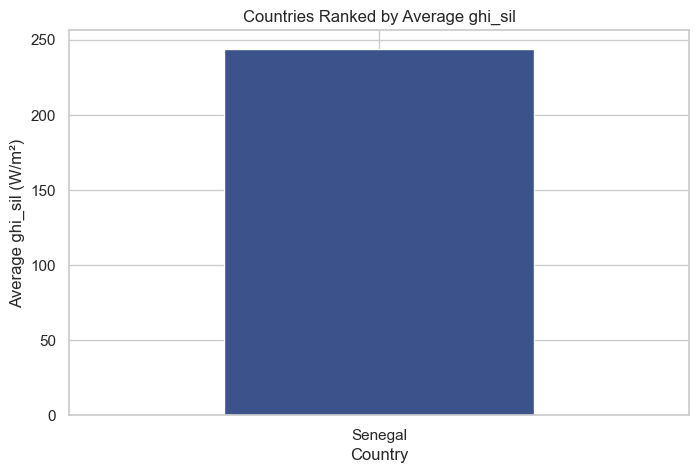

In [6]:
print("\n--- (Bonus) Visual Summary: Bar Chart Ranking by Average GHI ---")

if 'summary_table' in locals() and (GHI_COL, 'mean') in summary_table.columns:
    # Extract the mean GHI for each country
    avg_ghi_ranking = summary_table[(GHI_COL, 'mean')].sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    avg_ghi_ranking.plot(kind='bar', color=sns.color_palette('viridis', len(COUNTRIES)))
    plt.title(f'Countries Ranked by Average {GHI_COL}')
    plt.xlabel('Country')
    plt.ylabel(f'Average {GHI_COL} (W/m²)')
    plt.xticks(rotation=0)
    plt.show()
elif 'combined_df' in locals() and GHI_COL in combined_df.columns:
    # Fallback if summary_table structure is different or GHI_COL not directly tupled
    print("Attempting fallback for GHI ranking if summary_table format differs...")
    try:
        avg_ghi_fallback = combined_df.groupby('country')[GHI_COL].mean().sort_values(ascending=False)
        plt.figure(figsize=(8, 5))
        avg_ghi_fallback.plot(kind='bar', color=sns.color_palette('viridis', len(COUNTRIES)))
        plt.title(f'Countries Ranked by Average {GHI_COL} (Fallback)')
        plt.xlabel('Country')
        plt.ylabel(f'Average {GHI_COL} (W/m²)')
        plt.xticks(rotation=0)
        plt.show()
    except Exception as e:
        print(f"Could not generate bonus GHI ranking chart (fallback failed): {e}")
else:
    print(f"Could not generate bonus GHI ranking chart: 'summary_table' or '{GHI_COL}' mean not found.")